# Итоговый проект по курсу "Рекомендательные системы"

## 1. Модель

Было принято решение использовать двухуровневую модель. С помощью модели <b>ALS</b> предсказываем пул потенциально полезных рекомендаций для пользователя, после ранжируем полученные товары с помощью <b>LGBMClassifier<b><br>

Параметры <b>ALS:</b><br>
n_factors: 250 <br>
regularization: 0.01 <br>
iterations: 120

Параметры <b>LGBMClassifier:</b><br>
'n_estimators': 2000,<br>
'learning_rate': 0.1,<br>
'max_depth': 13,<br>
'categorical_column': cat_feats,<br>
'random_state': 100,<br>
'objective': 'binary',<br>
'metric': 'auc'<br>


## 2. Префильтрация и глобальные параметры

<b>Исходя из задачи были выбраны следующие параметры:</b> <br>
n_popular = 6000. Из всех товаров мы оставляем только 6000 самых популярных, чтобы ускорить обучение ALS и отфильтровать явно непопулярные товары<br><br>
K_N = 300. Количество кандидатов для каждого пользователя, которые ALS будет предоставлять для дальнейшего ранжирования с помощью LGBM.<br><br>
Параметр слишком дорогих товаров установлен на уровне 17$. В какой-то мере это можно назвать трюком, чтобы уложиться в заданные требования по метрике. <br><br>
Часть бизнес требований выполнены в префильтрации, часть в постфильтрации (см. ниже)

## 3. Новые признаки для классификатора

<b> Новые фичи </b> <br>
средняя корзина пользователя по сумме покупок<br>
средняя корзина пользователя по кол-ву покупок<br>
количество уникальных магазинов, в которых был пользователь<br>
количество уникальных товаров пользователя<br>
минимальное значение coupon_match_disc_min пользователя<br>
количество покупок пользователя в каждом департаменте<br>
средняя цена товара (цена меняется от неделе к неделе, возможно и от магазина к магазину)<br>
дисперсия количества покупок по депиртаментам<br>
доля товаров по пользователю купленных со скидкой<br><br>
<b>Признаки неизвестных пользователей заполнены модой</b>


## 4. Постфильтрация

<b>После ранжирования предсказаний идет две операции фильтрации </b><br>
1) Удаление дубликатов <br>

2) Проверка топ5 предсказаний на полное совпадение с историей покупок пользователя. Если пользователь уже покупал все 5 рекомендуемых товаров, то 5-ую рекомендацию меняем на следующую из ранжированного списка.

## 5. Результат

<b>Итоговый precision@5 с учетом всех бизнес требований - 0.274045 </b>


## 6. Сложности

1) Плохая стратегия по замене товара для требования хотя бы одной покупки не из списка предыдущих. Без данной фильтрации <b> precision@5 составляет 0.319980 </b><br>
2) Изменение количества недель на обучение модели первого и второго уровня получаем ухудшение итогой метрики. Даже если эти периоды становяться больше <br>
3) Большая часть предсказаний - это в каком-то виде именно история покупок. <br>
4) Один признак слишком сильный (см. конец работы)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import lightgbm as lgbm

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items, featuring, postfitlering, check_history
from src.recommenders import MainRecommender

In [2]:
n_popular = 6000
K_N = 300

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


In [4]:
val_lvl_1_size_weeks = 14   # 14 is ok
val_lvl_2_size_weeks = 3


data_for_features = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]


# недели 1-85 из 95  Length: 2108779
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

# недели 86-91 из 95 Length: 169711
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]



data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=n_popular)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Pavel\Documents\jupyter\recomend\course\src\utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 79281 to 5929


# Модель первого уровня 

In [6]:
recommender = MainRecommender(data_train_lvl_1, weighting=True)

In [7]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[1069297, 826695, 833988, 844818, 856942, 8607..."
1,2,"[825343, 826784, 833598, 858091, 885023, 88951..."


In [8]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_N))

In [9]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=K_N))

In [10]:
models = result_lvl_1.columns[2:]
score = []
for model_ in models:
    score.append(result_lvl_1.apply(lambda x: recall_at_k(x[model_], x['actual'], k=K_N), axis=1).mean())    

evaluation = pd.DataFrame({'model': models, 'recall': score})
evaluation.sort_values('recall', ascending=False)

,model,recall
0,als,0.213521
1,own,0.185474


In [11]:
models = result_lvl_1.columns[2:]
score = []
for model_ in models:
    score.append(result_lvl_1.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())    

evaluation = pd.DataFrame({'model': models, 'precision': score})
evaluation.sort_values('precision', ascending=False)

,model,precision
1,own,0.268038
0,als,0.259811


#### выбираем всё-таки ALS, поскольку у него выше RECALL. 

# Модель второго уровня.

In [12]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_N))

In [13]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [14]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()

targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [15]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
1885499,2070,35865687243,538,1085604,1,1.00,311,-0.29,14,78,0.0,0.0
1888231,2200,35877350475,538,840601,1,1.33,334,-0.06,1153,78,0.0,0.0


In [16]:
data_train_lvl_2 = prefilter_items(data_train_lvl_2, item_features=item_features, take_n_popular=n_popular)

C:\Users\Pavel\Documents\jupyter\recomend\course\src\utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


In [17]:
# targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
# targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1133018,1.0
1,2070,1133018,1.0


In [18]:
targets_lvl_2 = featuring(targets_lvl_2, data_for_features, user_features, item_features)

In [20]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [59]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,mean_basket_quantity,shops_number,items_number,coupon_match_disc,quantity_per_department,sales_value,quantity,value,var_per_department,disc_ratio
0,2070,1133018,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,45-54,U,...,227.655031,5,1068,-0.5,7.161622,12995.06,10830,1.199913,0.904489,0.662325
1,2070,1133018,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,45-54,U,...,227.655031,5,1068,-0.5,7.161622,12995.06,10830,1.199913,0.904489,0.662325


In [22]:
cat_feats = X_train.columns[2:16].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'mean_basket_value']

In [23]:
len(cat_feats)

14

In [24]:
params = { 
    'n_estimators': 2000,
    'learning_rate': 0.1,
    'max_depth': 13,
    'categorical_column': cat_feats,
    'random_state': 100,
    'objective': 'binary',
    'metric': 'auc'
}

In [25]:
lgb = LGBMClassifier(**params)
lgb.fit(X_train[X_train.columns[2:]], y_train)

C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Pavel\Anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc',
                                   'mean_basket_value'],
               max_depth=13, metric='auc', n_estimators=2000,
               objective='binary', random_state=100)

In [26]:
train_preds = lgb.predict_proba(X_train[X_train.columns[2:]])

In [63]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [64]:
result_lvl_2['als'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_N))

In [65]:
df_1=pd.DataFrame({'user_id':result_lvl_2.user_id.values.repeat(len(result_lvl_2.als[0])),
                 'item_id':np.concatenate(result_lvl_2.als.values)})

In [66]:
# df_1 = df_1.merge(item_features, on='item_id', how='left')
# df_1 = df_1.merge(user_features, on='user_id', how='left')

df_1.head(2)

,user_id,item_id
0,1,9527290
1,1,986912


In [67]:
df_1 = featuring(df_1, data_for_features, user_features, item_features)

In [68]:
cat_feats = df_1.columns[2:16].tolist()
df_1[cat_feats] = df_1[cat_feats].astype('category')

In [69]:
preds_val_2 = lgb.predict_proba(df_1[df_1.columns[2:]])

In [70]:
df_1['preds'] = preds_val_2[:, 1]

In [71]:
ranking = df_1[['user_id', 'item_id', 'preds']].sort_values(['user_id', 'preds'], ascending=[True,False]).copy()

In [72]:
result_lvl_2['lgbm'] = result_lvl_2['user_id'].apply(lambda x:ranking['item_id'].loc[ranking.user_id == x].values[:K_N])

In [73]:
result_lvl_2['own'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=K_N))

In [74]:
result_lvl_2['top'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_top_recommendations(x, N=K_N))

In [75]:
result_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2042 non-null   int64 
 1   actual   2042 non-null   object
 2   als      2042 non-null   object
 3   lgbm     2042 non-null   object
 4   own      2042 non-null   object
 5   top      2042 non-null   object
dtypes: int64(1), object(5)
memory usage: 95.8+ KB


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

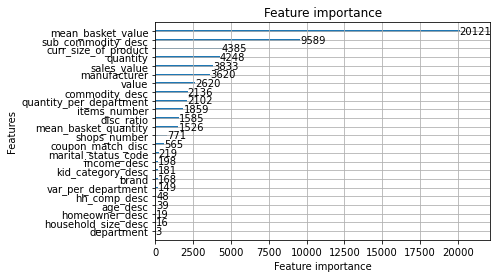

In [76]:
lgbm.plot_importance(lgb, max_num_features=24)

In [77]:
# история покупок товаров
users_history = data.groupby('user_id')['item_id'].unique().reset_index()

In [78]:
users_history = users_history.rename(columns={'item_id': 'history'})

In [79]:
result_lvl_2 = result_lvl_2.merge(users_history, on='user_id', how='left')

In [80]:
result_lvl_2['lgbm_filtered'] = result_lvl_2['lgbm'].apply(lambda x: postfitlering(x))

In [81]:
result_lvl_2['lgbm_filtered'] = result_lvl_2['user_id'].apply(lambda x:\
                              check_history(
                                            x, result_lvl_2.loc[result_lvl_2.user_id==x, 'lgbm_filtered'].values[0],
                                            result_lvl_2.loc[result_lvl_2.user_id==x, 'history'].values[0],
                                            result_lvl_2.loc[result_lvl_2.user_id==x, 'als'].values[0]
                                           )
                             )

In [62]:
models = result_lvl_2.columns[2:]
score = []
for model_ in models:
    score.append(result_lvl_2.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())    

evaluation = pd.DataFrame({'model': models, 'precision': score})
evaluation.sort_values('precision', ascending=False)

,model,precision
1,lgbm,0.319980
5,lgbm_filt,0.274045
6,lgbm_filtered,0.274045
3,top,0.137120
2,own,0.135455
0,als,0.134280
4,history,0.073947
